<a href="https://colab.research.google.com/github/forexms78/AI-05-/blob/main/%EB%AF%B8%EC%85%988_7%ED%8C%80_%EB%B0%95%EB%B3%91%ED%98%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title import문 정리

import os
import random
import collections
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms.v2 as v2
import torchvision.transforms.functional as F
from torchvision.tv_tensors import Image, Mask
from tqdm import tqdm

In [2]:
# @title 구글드라이브 연동

from google.colab import drive

# 드라이브 마운트
drive.mount('/content/drive')

# device 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Mounted at /content/drive
cuda


In [3]:
# @title 캐글 데이터 다운

import kagglehub

# Download latest version
path = kagglehub.dataset_download("sadhliroomyprime/football-semantic-segmentation")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'football-semantic-segmentation' dataset.
Path to dataset files: /kaggle/input/football-semantic-segmentation


In [4]:
# @title 폴더 내 이미지 가져오기

image_folder = os.path.join(path, "images")
file_list = os.listdir(image_folder)

print(f"file_list: {len(file_list)}")
print(file_list)

file_list: 300
['Frame 1  (68).jpg___fuse.png', 'Frame 1  (96).jpg', 'Frame 1  (41).jpg', 'Frame 1  (85).jpg___fuse.png', 'Frame 1  (41).jpg___save.png', 'Frame 1  (48).jpg', 'Frame 1  (14).jpg___save.png', 'Frame 1  (83).jpg', 'Frame 1  (39).jpg___fuse.png', 'Frame 1  (47).jpg___fuse.png', 'Frame 1  (74).jpg', 'Frame 1  (24).jpg___fuse.png', 'Frame 1  (52).jpg', 'Frame 1  (63).jpg___fuse.png', 'Frame 1  (18).jpg___fuse.png', 'Frame 1  (72).jpg___save.png', 'Frame 1  (50).jpg___save.png', 'Frame 1  (16).jpg___fuse.png', 'Frame 1  (84).jpg___fuse.png', 'Frame 1  (57).jpg___save.png', 'Frame 1  (13).jpg___fuse.png', 'Frame 1  (37).jpg', 'Frame 1  (37).jpg___fuse.png', 'Frame 1  (80).jpg___fuse.png', 'Frame 1  (9).jpg___save.png', 'Frame 1  (100).jpg', 'Frame 1  (64).jpg', 'Frame 1  (70).jpg', 'Frame 1  (88).jpg___save.png', 'Frame 1  (7).jpg___save.png', 'Frame 1  (69).jpg', 'Frame 1  (1).jpg', 'Frame 1  (4).jpg', 'Frame 1  (19).jpg___save.png', 'Frame 1  (56).jpg', 'Frame 1  (24).jpg', 

In [5]:
# @title 파일 이름으로 이미지 그룹화하기

original_images = sorted([f for f in file_list if f.endswith(".jpg")])
fuse_images = sorted([f for f in file_list if "fuse" in f])
save_images = sorted([f for f in file_list if "save" in f])

print("원본 이미지:", original_images)
print("fuse 이미지:", fuse_images)
print("save 이미지:", save_images)

원본 이미지: ['Frame 1  (1).jpg', 'Frame 1  (10).jpg', 'Frame 1  (100).jpg', 'Frame 1  (11).jpg', 'Frame 1  (12).jpg', 'Frame 1  (13).jpg', 'Frame 1  (14).jpg', 'Frame 1  (15).jpg', 'Frame 1  (16).jpg', 'Frame 1  (17).jpg', 'Frame 1  (18).jpg', 'Frame 1  (19).jpg', 'Frame 1  (2).jpg', 'Frame 1  (20).jpg', 'Frame 1  (21).jpg', 'Frame 1  (22).jpg', 'Frame 1  (23).jpg', 'Frame 1  (24).jpg', 'Frame 1  (25).jpg', 'Frame 1  (26).jpg', 'Frame 1  (27).jpg', 'Frame 1  (28).jpg', 'Frame 1  (29).jpg', 'Frame 1  (3).jpg', 'Frame 1  (30).jpg', 'Frame 1  (31).jpg', 'Frame 1  (32).jpg', 'Frame 1  (33).jpg', 'Frame 1  (34).jpg', 'Frame 1  (35).jpg', 'Frame 1  (36).jpg', 'Frame 1  (37).jpg', 'Frame 1  (38).jpg', 'Frame 1  (39).jpg', 'Frame 1  (4).jpg', 'Frame 1  (40).jpg', 'Frame 1  (41).jpg', 'Frame 1  (42).jpg', 'Frame 1  (43).jpg', 'Frame 1  (44).jpg', 'Frame 1  (45).jpg', 'Frame 1  (46).jpg', 'Frame 1  (47).jpg', 'Frame 1  (48).jpg', 'Frame 1  (49).jpg', 'Frame 1  (5).jpg', 'Frame 1  (50).jpg', 'Frame 1

In [6]:
# @title 이미지 그룹별 사이즈 확인

def unique_sizes(image_files, image_folder):

    unique_sizes = set()

    for image in image_files:
        img_path = os.path.join(image_folder, image)
        img = cv2.imread(img_path)

        height, width, channels = img.shape
        img_size = (height, width, channels)

        if img_size in unique_sizes:
            continue

        print(f"size check h,w,c: {height}, {width}, {channels}")
        unique_sizes.add(img_size)

print("기본 이미지")
unique_sizes(original_images, image_folder)

print("퓨즈 이미지")
unique_sizes(fuse_images, image_folder)

print("세이브 이미지")
unique_sizes(save_images, image_folder)

기본 이미지
size check h,w,c: 1080, 1920, 3
퓨즈 이미지
size check h,w,c: 1080, 1920, 3
세이브 이미지
size check h,w,c: 1080, 1920, 3


In [8]:
# @title 이미지 페어링

image_pairs = []
for original_image in original_images:
    base_name = original_image.replace(".jpg", "")
    fuse_image = next((f for f in fuse_images if base_name in f), None)
    save_image = next((f for f in save_images if base_name in f), None)

    if fuse_image and save_image:
        original_path = os.path.join(image_folder, original_image)
        fuse_path = os.path.join(image_folder, fuse_image)
        save_path = os.path.join(image_folder, save_image)

        orig = cv2.imread(original_path)
        fuse = cv2.imread(fuse_path)
        save = cv2.imread(save_path)

        if orig is not None and fuse is not None and save is not None:
            image_pairs.append((orig, fuse, save))

print(f"{len(image_pairs)} pairs")

100 pairs


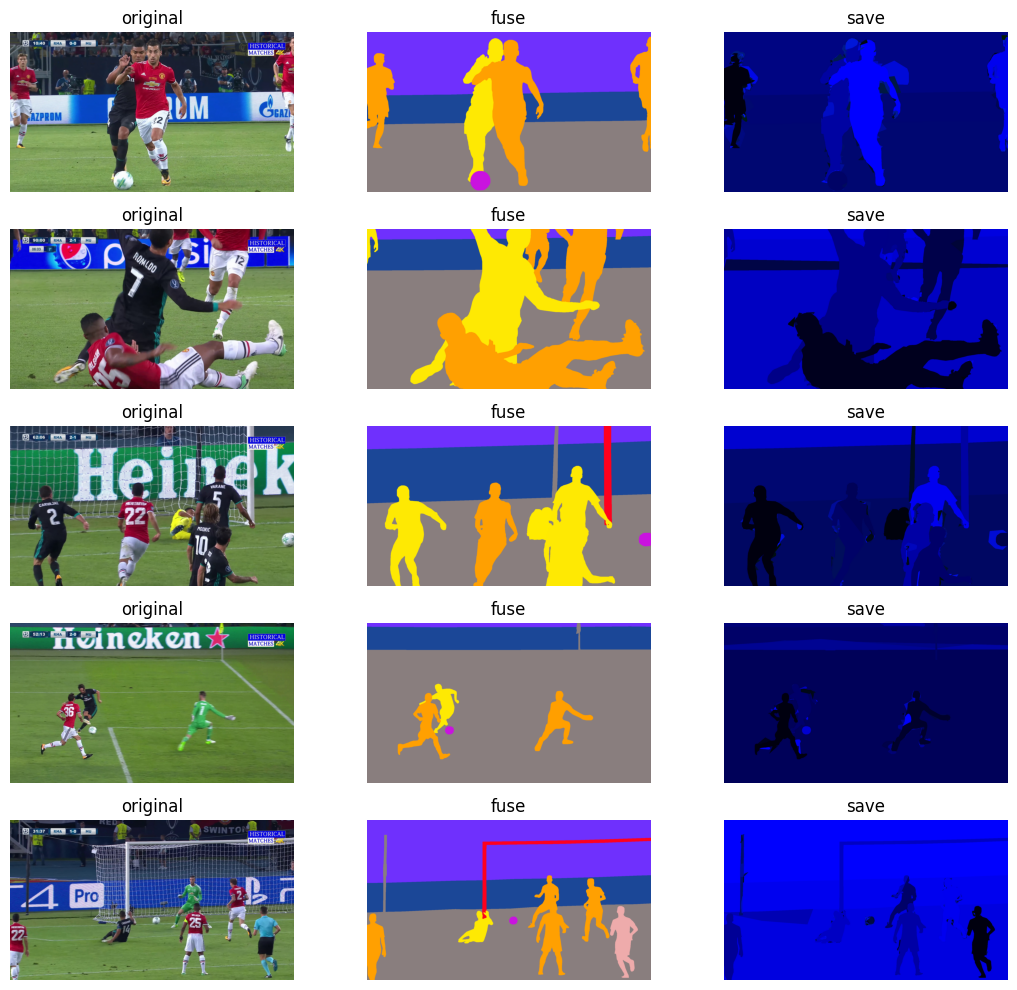

In [11]:
# @title 샘플이미지 시각화

num_samples = 5
sample_image_pairs = random.sample(image_pairs, num_samples)

fig, axes, = plt.subplots(num_samples, 3, figsize=(11, 10))

for i, (orig, fuse, save) in enumerate(sample_image_pairs):

    axes[i, 0].imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
    axes[i, 0].set_title("original")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(cv2.cvtColor(fuse, cv2.COLOR_BGR2RGB))
    axes[i, 1].set_title("fuse")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(cv2.cvtColor(save, cv2.COLOR_BGR2RGB))
    axes[i, 2].set_title("save")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()

In [15]:
# @title 마스크 이미지에서 색상 추출 함수

def get_unique_colors(image_folder, mask_files, max_classes=11):

    color_set = set()

    for mask_file in mask_files:
        mask_path = os.path.join(image_folder, mask_file)
        mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        unique_colors, _ = np.unique(mask.reshape(-1, 3), axis=0, return_counts=True)

        for color in unique_colors:
            if tuple(color) not in color_set:
                color_set.add(tuple(color))

                if len(color_set) >= max_classes:
                    return list(color_set)

    return list(color_set)

unique_colors = get_unique_colors(image_folder, fuse_images)
print(f"colors: {len(unique_colors)}")

color_to_label = {color: idx for idx, color in enumerate(unique_colors)}
print(color_to_label)

colors: 11
{(np.uint8(238), np.uint8(171), np.uint8(171)): 0, (np.uint8(254), np.uint8(233), np.uint8(3)): 1, (np.uint8(0), np.uint8(0), np.uint8(0)): 2, (np.uint8(255), np.uint8(0), np.uint8(29)): 3, (np.uint8(111), np.uint8(48), np.uint8(253)): 4, (np.uint8(137), np.uint8(126), np.uint8(126)): 5, (np.uint8(27), np.uint8(71), np.uint8(151)): 6, (np.uint8(255), np.uint8(160), np.uint8(1)): 7, (np.uint8(201), np.uint8(19), np.uint8(223)): 8, (np.uint8(255), np.uint8(159), np.uint8(0)): 9, (np.uint8(255), np.uint8(235), np.uint8(0)): 10}


In [16]:
# @title 파이토치 시맨틱 세그멘테이션용 데이터셋 정의 (모델에게 학습데이터 배정)

class FootballDataset(Dataset):

    def __init__(self, image_files, mask_files, image_folder, color_to_label, transform=None):
        self.image_files = image_files
        self.mask_files = mask_files
        self.image_folder = image_folder
        self.color_to_label = color_to_label
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_folder, self.image_files[idx])
        mask_path = os.path.join(self.image_folder, self.mask_files[idx])

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        if self.transform is None:
            img = cv2.resize(img, (256, 256)) / 255.0
            img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)

            mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)
            mask = torch.tensor(mask, dtype=torch.uint8).permute(2, 0, 1)
        else:
            img = Image(torch.from_numpy(img).permute(2, 0, 1))
            mask = Mask(torch.from_numpy(mask).permute(2, 0, 1))
            img, mask = self.transform(img, mask)

        mask_np = mask.permute(1, 2, 0).numpy()
        mask_class = np.zeros(mask_np.shape[:2], dtype=np.uint8)

        for color, label in self.color_to_label.items():
            match_pixels = np.all(mask_np == np.array(color), axis=-1)
            mask_class[match_pixels] = label

        mask = torch.tensor(mask_class, dtype=torch.long)
        return img, mask

In [18]:
# @title 데이터셋 분할 및 확인

dataset_size = len(original_images)
trainval_size = int(0.9 * dataset_size)
test_size = dataset_size - trainval_size

paired_files = list(zip(original_images, fuse_images))

trainval_files, test_files = random_split(paired_files, [trainval_size, test_size])

val_size = int(1/9 * trainval_size)
train_size = trainval_size - val_size
train_files, val_files = random_split(trainval_files, [train_size, val_size])

train_image_files, train_mask_files = zip(*train_files)
val_image_files, val_mask_files = zip(*val_files)
test_image_files, test_mask_files = zip(*test_files)

print("train 이미지 확인")
for img, mask in zip(train_image_files, train_mask_files):
    base_img = img.split(".jpg")[0]
    base_mask = mask.split(".jpg___fuse.png")[0]

    if base_img != base_mask:
        print(f"일치하지않음: {img} <-> {mask}")

print("val 이미지 확인")
for img, mask in zip(val_image_files, val_mask_files):
    base_img = img.split(".jpg")[0]
    base_mask = mask.split(".jpg___fuse.png")[0]
    if base_img != base_mask:
        print(f"일치하지않음: {img} <-> {mask}")

print("test 이미지 확인")
for img, mask in zip(test_image_files, test_mask_files):
    base_img = img.split(".jpg")[0]
    base_mask = mask.split(".jpg___fuse.png")[0]
    if base_img != base_mask:
        print(f"일치하지않음: {img} <-> {mask}")

train 이미지 확인
val 이미지 확인
test 이미지 확인
